Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Optimized CatBoost for Each Synthetic Data

* CTGAN synthetic data got most similar feature distributions as real data
* CastGAN synthetic data got best baseline model performance

In [1]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

import optuna
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Load Data

In [2]:
target = 'deposit'
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
raw_df[cat_cols] = raw_df[cat_cols].astype('category')
X_train, X_test, y_train, y_test = train_test_split(raw_df.drop(target, axis=1), raw_df[target], 
                                                    test_size=0.25, random_state=10,
                                                    stratify=raw_df[target])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

ctgan_syn_X_train = pd.read_csv('ctgan_syn_X_train_10.csv')
castgan_syn_X_train = pd.read_csv('CasTGAN/Generated_Data/wb_0/campaign_fake_20230901-2310.csv')
ctgan_syn_X_train[cat_cols] = ctgan_syn_X_train[cat_cols].astype('category')
castgan_syn_X_train[cat_cols] = castgan_syn_X_train[cat_cols].astype('category')

print(ctgan_syn_X_train.shape, castgan_syn_X_train.shape)

(8371, 16) (2791, 16) (8371,) (2791,)
(8371, 16) (8371, 16)


In [3]:
def get_opt_data(X_train, y_train, 
                 test_size=0.2, random_state=10,
                 stratify=y_train):
    opt_X_train, opt_X_val, opt_y_train, opt_y_val = train_test_split(X_train, y_train, 
                                                                      test_size=test_size,
                                                                      random_state=random_state,
                                                                      stratify=stratify)
    print(opt_X_train.shape, opt_y_train.shape, opt_X_val.shape, opt_y_val.shape)
    print(opt_y_train.value_counts()*100/opt_y_train.shape)
    print(opt_y_val.value_counts()*100/opt_y_val.shape)

    opt_X_train.reset_index(inplace=True, drop=True)
    opt_X_val.reset_index(inplace=True, drop=True)
    opt_y_train.reset_index(inplace=True, drop=True)
    opt_y_val.reset_index(inplace=True, drop=True)
    
    return opt_X_train, opt_X_val, opt_y_train, opt_y_val

In [4]:
ctgan_opt_X_train, ctgan_opt_X_val, ctgan_opt_y_train, ctgan_opt_y_val = get_opt_data(ctgan_syn_X_train, y_train, 
                                                                                      test_size=0.2,
                                                                                      random_state=10,
                                                                                      stratify=y_train)
print()

castgan_opt_X_train, castgan_opt_X_val, castgan_opt_y_train, castgan_opt_y_val = get_opt_data(castgan_syn_X_train, y_train, 
                                                                                      test_size=0.2,
                                                                                      random_state=10,
                                                                                      stratify=y_train)

(6696, 16) (6696,) (1675, 16) (1675,)
deposit
0    52.613501
1    47.386499
Name: count, dtype: float64
deposit
0    52.597015
1    47.402985
Name: count, dtype: float64

(6696, 16) (6696,) (1675, 16) (1675,)
deposit
0    52.613501
1    47.386499
Name: count, dtype: float64
deposit
0    52.597015
1    47.402985
Name: count, dtype: float64


## CatBoost Baseline

* CatBoost params: https://catboost.ai/en/docs/references/training-parameters/
  * Pay attention to the limits of `grow-policy`
* Some params are specified in `fit()`: https://catboost.ai/en/docs/concepts/python-reference_catboost_fit 

In [33]:
def get_model_performance(model_params, X_train, y_train, 
                          X_test, y_test, cat_cols,
                          plot_feat_impt=False):
    model = CatBoostClassifier(**model_params)
    model.fit(X_train, y_train, cat_features=cat_cols, verbose=False)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    avp = average_precision_score(y_test, y_pred)
    
    print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')
    
    if plot_feat_impt:
        feature_importance = model.get_feature_importance(type='PredictionValuesChange')
        sorted_idx = np.argsort(feature_importance)
        fig = plt.figure(figsize=(5, 10))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
        plt.title('Feature Importance')

In [6]:
model_params = {'iterations': 3000, 'loss_function': 'Logloss', 'learning_rate': 0.17937097905882862,
               'random_seed': 10, 'max_depth': 8, 'min_data_in_leaf': 1133}

get_model_performance(model_params, 
                      ctgan_syn_X_train, y_train,
                      X_test, y_test, cat_cols)

get_model_performance(model_params, 
                      castgan_syn_X_train, y_train,
                      X_test, y_test, cat_cols)

Testing AUC is 0.508411096086648, Testing Average Precision is 0.477952686631376
Testing AUC is 0.5587921945110705, Testing Average Precision is 0.506460003723822


## Tune CatBoost for Each Synthetic Data

* CatBoost params: https://catboost.ai/en/docs/references/training-parameters/
  * Pay attention to the limits of `grow-policy`
* Some params are specified in `fit()`: https://catboost.ai/en/docs/concepts/python-reference_catboost_fit 
* CatBoost feature importance: https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_get_feature_importance

In [14]:
def get_hpo_params(opt_X_train, opt_X_val, opt_y_train, opt_y_val, cat_cols, n_trials=180):
    """
        To make below optuna output reproducible, need to set hashseed in your OS: 
        https://gerrychain.readthedocs.io/en/latest/topics/reproducibility.html#set-pythonhashseed-0
        This is ot make pruning behaviour replicable.
    """
    
    def objective(trial):
        params = {
            'loss_function': 'Logloss',
            'random_seed': 10,

            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'num_trees': trial.suggest_int('max_depth', 2500, 3000),  # iterations
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1100, 2000),
            'subsample': trial.suggest_float('subsample', 0.8, 1),
            'grow_policy': trial.suggest_categorical('grow_policy', ['Depthwise', 'Lossguide', 'SymmetricTree'])
        }
        
        if params['grow_policy'] == 'Lossguide':
            params['max_leaves'] = trial.suggest_int('max_leaves', 5, 10)  # only available under `lossguide`
            
        clf = CatBoostClassifier(**params)  
        clf.fit(opt_X_train, opt_y_train, eval_set=[(opt_X_val, opt_y_val)],
                cat_features=cat_cols, verbose=False)

        y_val_pred = clf.predict(opt_X_val)
        avp = average_precision_score(opt_y_val, y_val_pred)
        return avp


    start = timeit.default_timer()
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner(),
                               sampler=optuna.samplers.TPESampler(seed=10), study_name='catboost_hpo')
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))
    best_trial = study.best_trial
    print(f"Best trial performance: {best_trial.value}")
    stop = timeit.default_timer()
    print('Time (min): ', (stop - start)/60)
    
    return best_trial.params


def get_best_params(constant_params, opt_X_train,
                    opt_X_val, opt_y_train, opt_y_val,
                    n_trials=180):
    best_params = get_hpo_params(opt_X_train, opt_X_val, opt_y_train, opt_y_val,
                                 n_trials=n_trials)
    best_params.update(constant_params)
    print(best_params)
    
    return best_params

In [35]:
constant_params = {'loss_function': 'Logloss', 'random_seed': 10}

ctgan_best_params = get_best_params(constant_params,
                    ctgan_opt_X_train, ctgan_opt_X_val, ctgan_opt_y_train, ctgan_opt_y_val,
                    n_trials=200)  # 500 trials didn't have much difference as 200 trials

castgan_best_params = get_best_params(constant_params,
                    castgan_opt_X_train, castgan_opt_X_val, castgan_opt_y_train, castgan_opt_y_val,
                    n_trials=200)  # 500 trials didn't have much difference as 200 trials

[I 2023-10-02 20:01:31,255] A new study created in memory with name: catboost_hpo
C:\Users\wuhan\anaconda3\envs\secret_guest\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "max_depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 3, 'high': 15}
  warnings.warn(
[I 2023-10-02 20:01:32,145] Trial 0 finished with value: 0.4741518547759384 and parameters: {'max_depth': 13, 'learning_rate': 0.0051296379225208985, 'min_data_in_leaf': 1670, 'subsample': 0.9497607765077224, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.4741518547759384.
C:\Users\wuhan\anaconda3\envs\secret_guest\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter

Number of finished trials: 200
Best trial performance: 0.4831028088613567
Time (min):  1.8023290666666678
{'max_depth': 7, 'learning_rate': 0.03767190865887794, 'min_data_in_leaf': 1295, 'subsample': 0.9480606825100655, 'grow_policy': 'SymmetricTree', 'loss_function': 'Logloss', 'random_seed': 10}


[I 2023-10-02 20:03:20,339] Trial 0 finished with value: 0.47402985074626863 and parameters: {'max_depth': 13, 'learning_rate': 0.0051296379225208985, 'min_data_in_leaf': 1670, 'subsample': 0.9497607765077224, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.47402985074626863.
C:\Users\wuhan\anaconda3\envs\secret_guest\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "max_depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 3, 'high': 15}
  warnings.warn(
[I 2023-10-02 20:03:21,167] Trial 1 finished with value: 0.47405706265362646 and parameters: {'max_depth': 12, 'learning_rate': 0.034653056475944556, 'min_data_in_leaf': 1179, 'subsample': 0.9370719636735595

Number of finished trials: 200
Best trial performance: 0.49304744881044743
Time (min):  14.754279836666653
{'max_depth': 14, 'learning_rate': 0.18602238460507703, 'min_data_in_leaf': 1121, 'subsample': 0.8622963382127652, 'grow_policy': 'SymmetricTree', 'loss_function': 'Logloss', 'random_seed': 10}


{'max_depth': 7, 'learning_rate': 0.03767190865887794, 'min_data_in_leaf': 1295, 'subsample': 0.9480606825100655, 'grow_policy': 'SymmetricTree', 'loss_function': 'Logloss', 'random_seed': 10}
Testing AUC is 0.5484583562047314, Testing Average Precision is 0.5021543049807888


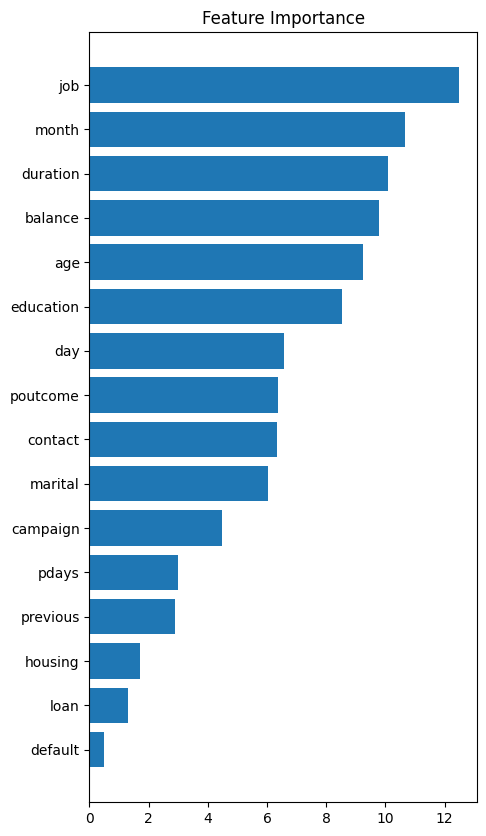

In [36]:
print(ctgan_best_params)
get_model_performance(ctgan_best_params, ctgan_syn_X_train, y_train, 
                      X_test, y_test, cat_cols,
                      plot_feat_impt=True)

{'max_depth': 14, 'learning_rate': 0.18602238460507703, 'min_data_in_leaf': 1121, 'subsample': 0.8622963382127652, 'grow_policy': 'SymmetricTree', 'loss_function': 'Logloss', 'random_seed': 10}
Testing AUC is 0.557804819522785, Testing Average Precision is 0.5067219248746861


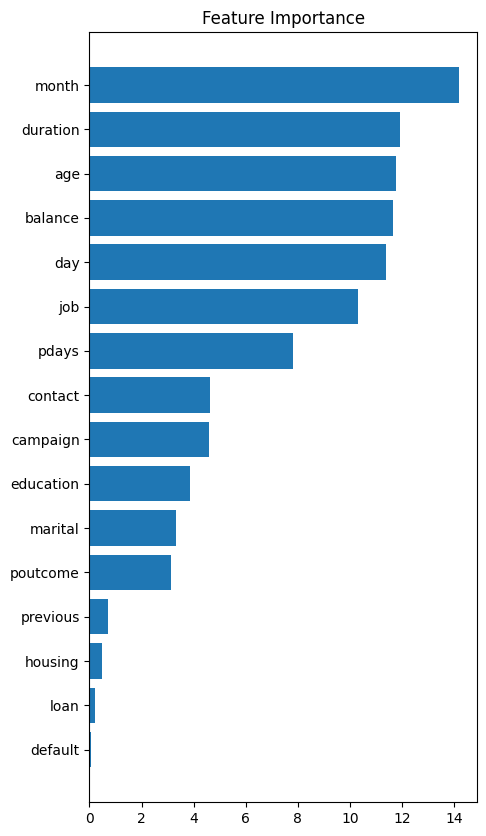

In [37]:
print(castgan_best_params)
get_model_performance(castgan_best_params, castgan_syn_X_train, y_train,
                      X_test, y_test, cat_cols,
                      plot_feat_impt=True)

## Summary

* For CTGAN synthetic data, selected param set is:
  * `{'max_depth': 7, 'learning_rate': 0.03767190865887794, 'min_data_in_leaf': 1295, 'subsample': 0.9480606825100655, 'grow_policy': 'SymmetricTree', 'loss_function': 'Logloss', 'random_seed': 10}`
  
* For CastGAN synthetic data, baseline works slightly better, the param set is:
  * `{'iterations': 3000, 'loss_function': 'Logloss', 'learning_rate': 0.17937097905882862, 'random_seed': 10, 'max_depth': 8, 'min_data_in_leaf': 1133}`